MODELO BERT SIN ENTRENAMIENTO

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joey_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joey_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Device set to use cpu



Precisión del modelo (FEEL vs sentiment): 71.40%
F1 Score del modelo (FEEL vs sentiment, weighted): 0.6730

F1 Score por clase:
Negative: 0.7670
Neutral: 0.0303
Positive: 0.7574

Distribución de sentimientos en df:
sentiment
Negative    579
Positive    410
Neutral      11
Name: count, dtype: int64

Distribución de sentimientos en df_evaluation (FEEL):
FEEL
positive    501
negative    378
neutral     121
Name: count, dtype: int64

Ejemplos de comparación entre FEEL y sentiment:
     CASE ID                                TRANSLATED COMMENTS      FEEL  \
0  CASE-1716        The phone team was amazing with my inquiry.  Positive   
1  CASE-1438  The chatbot was quick to assist with my transf...  Positive   
2  CASE-1039        Phone support was okay, nothing remarkable.   Neutral   
3  CASE-1173  The chatbot assisted me with my savings accoun...  Positive   
4  CASE-1792   The chatbot gave me outdated info about my fees.  Negative   
5  CASE-1185   The chatbot quickly helped me reset my p

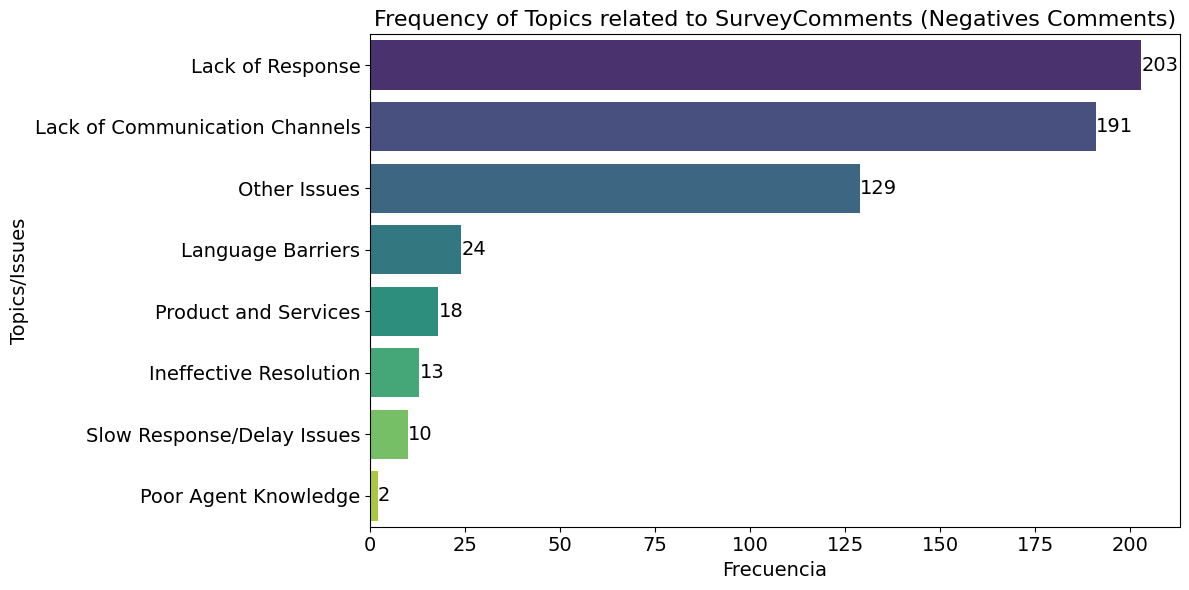

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import torch
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score  # Importar f1_score

# Descargar recursos de NLTK 
nltk.download('punkt')
nltk.download('wordnet')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Cargar el modelo BERT
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Leer el archivo de GitHub
file_path = 'https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/bank_call_center_feedback.csv'
df = pd.read_csv(file_path, quotechar='"', sep=';', encoding='utf-8')

# Crear df_evaluation con CASE ID
df_evaluation = df[['CASE ID', 'TRANSLATED COMMENTS', 'FEEL']].copy()

# Trabajar con el df original incluyendo CASE ID
df = df[['CASE ID', 'TRANSLATED COMMENTS']]

# 1. Análisis de sentimiento
def analyze_sentiment(comment):
    comment = str(comment).strip()
    if not comment or comment == "nan":
        return "NEUTRAL", 0.0
    result = sentiment_analyzer(comment, truncation=True, max_length=512)[0]
    label = result['label']
    score = result['score']
    if label == "POSITIVE":
        polarity = score
        sentiment = "Positive" if score > 0.7 else "Neutral"
    else:
        polarity = -score
        sentiment = "Negative" if score > 0.7 else "Neutral"
    return sentiment, polarity

# Aplicar análisis de sentimiento al df principal
df[['sentiment', 'polarity']] = df["TRANSLATED COMMENTS"].apply(analyze_sentiment).apply(pd.Series)

# Calcular precisión comparando FEEL con sentiment usando CASE ID para el merge
df_comparison = pd.merge(df_evaluation, df[['CASE ID', 'sentiment']], 
                        on='CASE ID', 
                        how='inner')

# Convertir a mayúsculas para consistencia en la comparación
df_comparison['FEEL'] = df_comparison['FEEL'].str.capitalize()
df_comparison['sentiment'] = df_comparison['sentiment'].str.capitalize()

# Calcular precisión
accuracy = accuracy_score(df_comparison['FEEL'], df_comparison['sentiment'])
print(f"\nPrecisión del modelo (FEEL vs sentiment): {accuracy:.2%}")

# Calcular F1 score (promedio weighted)
f1 = f1_score(df_comparison['FEEL'], df_comparison['sentiment'], average='weighted')
print(f"F1 Score del modelo (FEEL vs sentiment, weighted): {f1:.4f}")

# Calcular F1 score por clase (opcional, para más detalle)
f1_per_class = f1_score(df_comparison['FEEL'], df_comparison['sentiment'], average=None, labels=['Negative', 'Neutral', 'Positive'])
print("\nF1 Score por clase:")
for label, score in zip(['Negative', 'Neutral', 'Positive'], f1_per_class):
    print(f"{label}: {score:.4f}")

# Mostrar distribución de sentimientos
print("\nDistribución de sentimientos en df:")
print(df['sentiment'].value_counts())
print("\nDistribución de sentimientos en df_evaluation (FEEL):")
print(df_evaluation['FEEL'].value_counts())

# Mostrar algunas comparaciones, incluyendo CASE ID
print("\nEjemplos de comparación entre FEEL y sentiment:")
print(df_comparison[['CASE ID', 'TRANSLATED COMMENTS', 'FEEL', 'sentiment']].head(10))

# Continuar con el procesamiento original
df_nn = df[df['sentiment'].isin(['Negative', 'Neutral'])].copy()
comments_nn = df_nn["TRANSLATED COMMENTS"].tolist()
print(f"\nNúmero de comentarios Negativos y Neutrales: {len(comments_nn)}")

print("\nEjemplos de comentarios con puntajes:")
print(df[["CASE ID", "TRANSLATED COMMENTS", 'sentiment', 'polarity']].head(20))

# 2. Listado predefinido de issues
predefined_issues = {
    "Slow Response/Delay Issues": ["faster","feedback","slow", "answer", "solution" , "wait", "long", "wait", "late", "take", "forever", "reply", "frustrate"],
    "Poor Agent Knowledge": ["know", "prepare", "confuse", "wrong", "incompetent", "expert"],
    "Poor Support Quality": ["rude", "help", "attitude", "confuse", "incompetent", "understand", "agent"],
    "Fraud/Trust Issues": ["fraud", "scam", "trust", "secure", "money", "pay", "fake", "hack", "safe"],
    "Product and Services": ["account", "service", "term", "policy", "product", "avail", "refund"],
    "Platform Functionality": ["app","api","platform", "system", "error", "bug", "crash", "technical", "happen"],
    "Lack of Communication Channels": ["phone", "email", "contact", "call", "chat", "verbal","operator","agent"],
    "Lack of Response": ["assistance","receive","any","request", "support" ,"contact","respond", "answer", "no one", "get", "feedback", "question", "nobody", "silent","call"],
    "Ineffective Resolution": ["unsuccessful","request","resolve", "problem", "solve", "fix", "nothing", "resolution"],
    "Language Barriers": ["portuguese", "help", "speaker", "native", "spanish", "english", "language", "italian", "translate", "speak"]
}

# Funciones de lematización y asignación de issues
def lemmatize_text(text):
    words = word_tokenize(text.lower())
    lemmatized_words = {lemmatizer.lemmatize(word) for word in words}
    return lemmatized_words

def assign_issue(comment):
    comment_words = lemmatize_text(comment)
    max_overlap = 0
    best_issue = "Other Issues"
    for issue, issue_keywords in predefined_issues.items():
        overlap = len(comment_words.intersection(set(issue_keywords)))
        if overlap > max_overlap or (overlap == max_overlap and issue in ["Lack of Response", "Language Barriers", "Platform Functionality", "Poor Support Quality", "Poor Agent Knowledge", "Product and Services", "Fraud/Trust Issues", "Lack of Communication Channels"]):
            max_overlap = overlap
            best_issue = issue
    return best_issue if max_overlap > 0 else "Other Issues"

# Asignar issues
df_nn['issue'] = df_nn["TRANSLATED COMMENTS"].apply(assign_issue)

# 3. Validación
print("\nComentarios con sus issues asignados:")
print(df_nn[["CASE ID", "TRANSLATED COMMENTS", 'sentiment', 'polarity', 'issue']])

# 4. Visualización de frecuencias
plt.figure(figsize=(12, 6))
issue_counts = df_nn['issue'].value_counts()
sns.barplot(x=issue_counts.values, y=issue_counts.index, palette="viridis", hue=issue_counts.index)
plt.xlabel('Frecuencia', size=14)
plt.ylabel('Topics/Issues', size=14)
plt.title('Frequency of Topics related to SurveyComments (Negatives Comments)', size=16)
for i, v in enumerate(issue_counts.values):
    plt.text(v, i, str(v), va='center', size=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

In [2]:
df_comparison.head(10)

,CASE ID,TRANSLATED COMMENTS,FEEL,sentiment
0,CASE-1716,The phone team was amazing with my inquiry.,Positive,Positive
1,CASE-1438,The chatbot was quick to assist with my transf...,Positive,Negative
2,CASE-1039,"Phone support was okay, nothing remarkable.",Neutral,Negative
3,CASE-1173,The chatbot assisted me with my savings accoun...,Positive,Positive
4,CASE-1792,The chatbot gave me outdated info about my fees.,Negative,Negative
5,CASE-1185,The chatbot quickly helped me reset my password.,Positive,Negative
6,CASE-1785,"Email support was okay, not very detailed.",Neutral,Negative
7,CASE-1282,The chatbot was okay with my rewards query.,Neutral,Positive
8,CASE-1445,"Phone support was terrible, they wasted my time.",Negative,Negative
9,CASE-1203,The chatbot was decent with my payment request.,Neutral,Positive


MODELO PRE-ENTRENADO VADER

Valores únicos en FEEL (sin procesar):
['positive' 'neutral' 'negative']

Valores nulos en FEEL: 0
Valores nulos en TRANSLATED COMMENTS: 0

Valores únicos en FEEL (después de preprocesamiento):
['Positive' 'Neutral' 'Negative']

Primeras filas de la muestra (df_sample):
     CASE ID                                TRANSLATED COMMENTS      FEEL
0  CASE-1716        The phone team was amazing with my inquiry.  Positive
1  CASE-1438  The chatbot was quick to assist with my transf...  Positive
2  CASE-1039        Phone support was okay, nothing remarkable.   Neutral
3  CASE-1173  The chatbot assisted me with my savings accoun...  Positive
4  CASE-1792   The chatbot gave me outdated info about my fees.  Negative
Texto: The phone team was amazing with my inquiry.... | Puntaje: 0.5859
Texto: The chatbot was quick to assist with my transfer r... | Puntaje: 0.0
Texto: Phone support was okay, nothing remarkable.... | Puntaje: 0.1719
Texto: The chatbot assisted me with my savings account in... | Pu

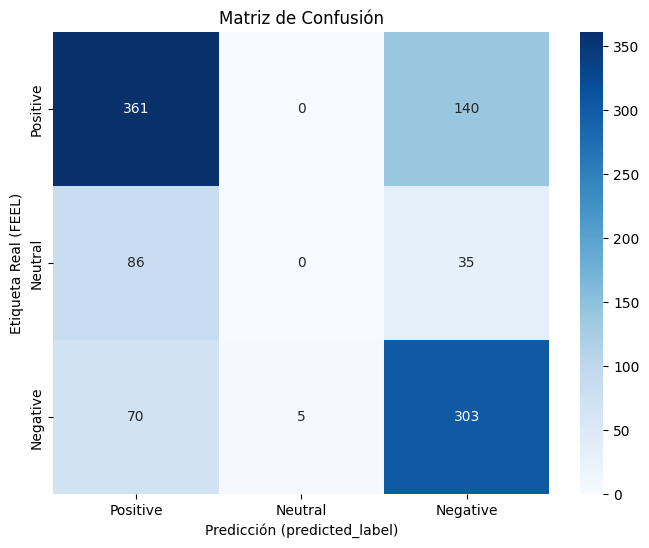


Precisión del modelo (comparando FEEL y predicted_label): 66.40%
F1-Score del modelo (weighted): 0.6229

F1-Score por clase:
Positive: 0.7092
Neutral: 0.0000
Negative: 0.7079


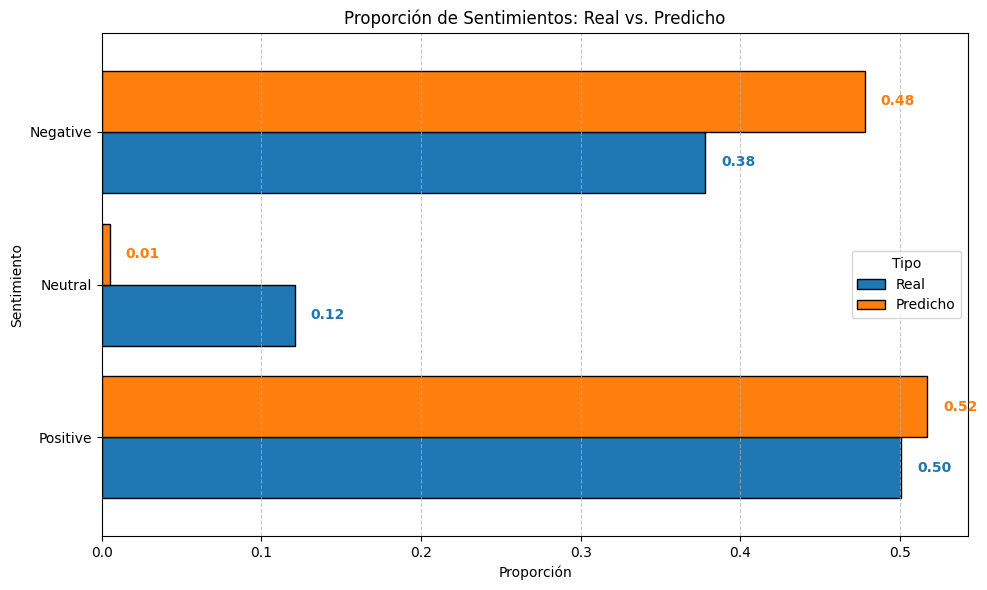

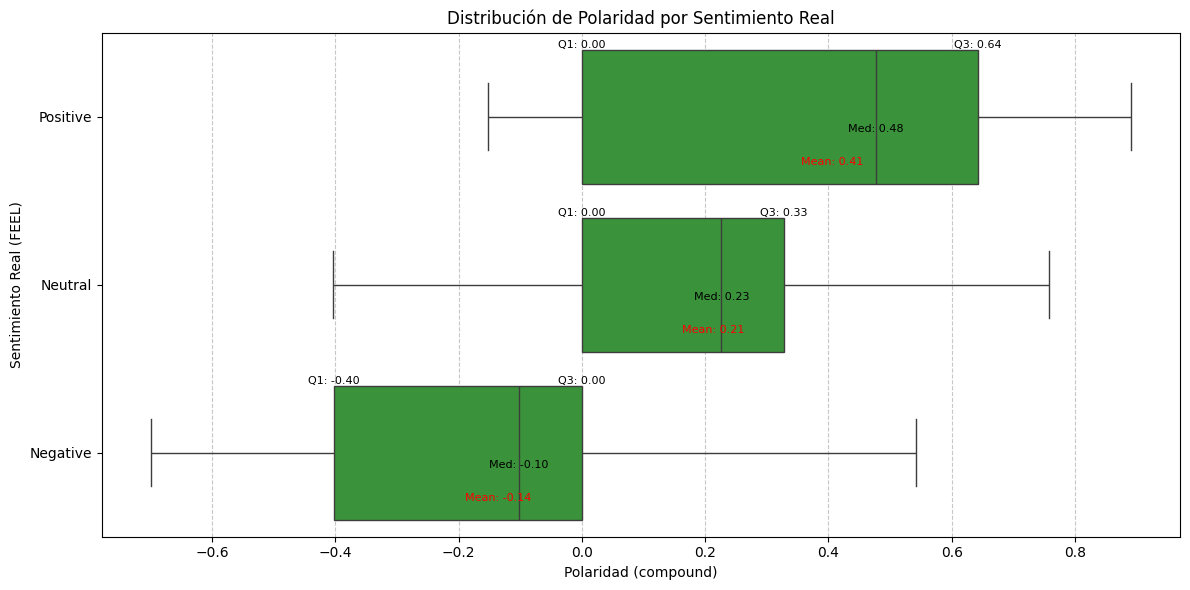

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score  # Importar f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Leer el archivo desde GitHub
file_path = 'https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/bank_call_center_feedback.csv'
df = pd.read_csv(file_path, quotechar='"', sep=';', encoding='utf-8')

# Tomar una muestra de todas las filas
df_sample = df.copy()

# Inspeccionar valores únicos y verificar nulos
print("Valores únicos en FEEL (sin procesar):")
print(df_sample['FEEL'].unique())
print("\nValores nulos en FEEL:", df_sample['FEEL'].isnull().sum())
print("Valores nulos en TRANSLATED COMMENTS:", df_sample['TRANSLATED COMMENTS'].isnull().sum())

# Preprocesar FEEL: estandarizar a mayúsculas y eliminar espacios
df_sample['FEEL'] = df_sample['FEEL'].str.strip().str.capitalize()

# Verificar valores después de preprocesamiento
print("\nValores únicos en FEEL (después de preprocesamiento):")
print(df_sample['FEEL'].unique())

# Mostrar primeras filas
print("\nPrimeras filas de la muestra (df_sample):")
print(df_sample[['CASE ID', 'TRANSLATED COMMENTS', 'FEEL']].head())

# Inicializar VADER
analyzer = SentimentIntensityAnalyzer()

# Función para analizar sentimiento
def vader_to_scale(translated_text):
    score = analyzer.polarity_scores(translated_text)['compound']
    print(f"Texto: {translated_text[:50]}... | Puntaje: {score}")
    if score > 0.1:  # Positive
        return 'Positive'
    elif score < 0.01:  # Negative
        return 'Negative'
    else:  # Neutral
        return 'Neutral'

# Aplicar VADER y guardar polaridad
df_sample['polarity'] = df_sample['TRANSLATED COMMENTS'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_sample['predicted_label'] = df_sample['TRANSLATED COMMENTS'].apply(vader_to_scale)

# Verificar valores predichos
print("\nValores únicos en predicted_label:")
print(df_sample['predicted_label'].unique())
print("Valores nulos en predicted_label:", df_sample['predicted_label'].isnull().sum())

# Filtrar filas con valores válidos
df_sample_valid = df_sample.dropna(subset=['FEEL', 'predicted_label'])
print("\nNúmero de filas válidas después de filtrar nulos:", len(df_sample_valid))

# Mostrar distribución
print("\nDistribución de etiquetas reales (FEEL) en datos válidos:")
print(df_sample_valid['FEEL'].value_counts())
print("\nDistribución de etiquetas predichas (predicted_label) en datos válidos:")
print(df_sample_valid['predicted_label'].value_counts())

# Mostrar resultados
print("\nMuestra de resultados:")
print(df_sample_valid[['CASE ID', 'TRANSLATED COMMENTS', 'FEEL', 'predicted_label', 'polarity']].head(10))

# Definir etiquetas para la matriz de confusión
labels = ['Positive', 'Neutral', 'Negative']

# Matriz de confusión
try:
    conf_matrix = confusion_matrix(df_sample_valid['FEEL'], df_sample_valid['predicted_label'], labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción (predicted_label)')
    plt.ylabel('Etiqueta Real (FEEL)')
    plt.title('Matriz de Confusión')
    plt.show()
except ValueError as e:
    print(f"Error en la matriz de confusión: {e}")

# Calcular y mostrar precisión
accuracy = accuracy_score(df_sample_valid['FEEL'], df_sample_valid['predicted_label'])
print(f"\nPrecisión del modelo (comparando FEEL y predicted_label): {accuracy * 100:.2f}%")

# Calcular F1-score (promedio weighted)
f1_weighted = f1_score(df_sample_valid['FEEL'], df_sample_valid['predicted_label'], average='weighted', labels=labels)
print(f"F1-Score del modelo (weighted): {f1_weighted:.4f}")

# Calcular F1-score por clase
f1_per_class = f1_score(df_sample_valid['FEEL'], df_sample_valid['predicted_label'], average=None, labels=labels)
print("\nF1-Score por clase:")
for label, score in zip(labels, f1_per_class):
    print(f"{label}: {score:.4f}")

# Calcular proporciones para la gráfica de proporciones
real_counts = df_sample_valid['FEEL'].value_counts(normalize=True).reindex(labels, fill_value=0)
pred_counts = df_sample_valid['predicted_label'].value_counts(normalize=True).reindex(labels, fill_value=0)

proportions = pd.DataFrame({
    'Real': real_counts,
    'Predicho': pred_counts
})

# Gráfica de barras horizontales con etiquetas afuera
fig, ax = plt.subplots(figsize=(10, 6))
proportions.plot(kind='barh', width=0.8, color=['#1f77b4', '#ff7f0e'], edgecolor='black', ax=ax)
plt.xlabel('Proporción')
plt.ylabel('Sentimiento')
plt.title('Proporción de Sentimientos: Real vs. Predicho')
plt.legend(title='Tipo')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, (real_val, pred_val) in enumerate(zip(proportions['Real'], proportions['Predicho'])):
    ax.text(real_val, i - 0.2, f'{real_val:.2f}', ha='left', va='center', fontweight='bold', color='#1f77b4', 
            position=(real_val + 0.01, i - 0.2))
    ax.text(pred_val, i + 0.2, f'{pred_val:.2f}', ha='left', va='center', fontweight='bold', color='#ff7f0e', 
            position=(pred_val + 0.01, i + 0.2))

plt.tight_layout()
plt.show()

# Boxplot de polaridad por sentimiento real
plt.figure(figsize=(12, 6))
sns.boxplot(x='polarity', y='FEEL', data=df_sample_valid, order=labels, color='#2ca02c')
plt.xlabel('Polaridad (compound)')
plt.ylabel('Sentimiento Real (FEEL)')
plt.title('Distribución de Polaridad por Sentimiento Real')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Calcular estadísticas para etiquetas
for i, label in enumerate(labels):
    data = df_sample_valid[df_sample_valid['FEEL'] == label]['polarity']
    if len(data) > 0:
        q1, median, q3 = data.quantile([0.25, 0.5, 0.75])
        mean = data.mean()
        # Posicionar etiquetas en el boxplot
        plt.text(q1, i - 0.4, f'Q1: {q1:.2f}', ha='center', va='bottom', fontsize=8, color='black')
        plt.text(median, i + 0.1, f'Med: {median:.2f}', ha='center', va='bottom', fontsize=8, color='black')
        plt.text(q3, i - 0.4, f'Q3: {q3:.2f}', ha='center', va='bottom', fontsize=8, color='black')
        plt.text(mean, i + 0.3, f'Mean: {mean:.2f}', ha='center', va='bottom', fontsize=8, color='red')

plt.tight_layout()
plt.show()